In [1]:
import numpy as np
import pandas as pd
import zipfile
import re
from tinydb import TinyDB, Query
import random
import urllib as urllib2
import nltk
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
import wget, os
import time

## database

In [12]:
content_db = TinyDB('../database/db.json')

## downloading txt files

In [13]:
def get_links():
    url = 'https://www.google.com/googlebooks/uspto-patents-grants-text.html'
    resp = urllib2.request.urlopen(url)
    soup = BeautifulSoup(resp.read())
    links = [a['href'] for a in soup.find_all('a', href=True)]
    return links[733:]
zips = get_links()

In [14]:
def extract_zip(z, zip_path, txt_path):
    zip_dir = zip_path + z[-10:]
    
    try:
        filename = wget.download(z, out = zip_dir)
    except:
        return None
    
    zip_ref = zipfile.ZipFile(zip_dir, 'r')
    zip_ref.extractall(txt_path)
    zip_ref.close() 
    return zip_dir

In [15]:
def get_txt_content(filepath, approved):
    # returns raw text and relevant metadata
    def approve_line(line, approved):
        if not line[2].isupper(): return True
        for a in approved:
            if a in line:
                return True
        return False

    contents = []
    for line in open(filepath, 'rb'):
        if approve_line(str(line), approved): 
            contents.append(str(line.strip()))
    return contents

In [27]:
def preprocess_doc(docs):
    new_docs = []
    toktok = ToktokTokenizer()
    to_remove = [r'FIG. [1-9]', 'PAL',  'PNO', 'b\'', '\'']
    
    stopword_list = nltk.corpus.stopwords.words('english')
    
    stopword_list.append('said')
    stopword_list.append('b')
    stopword_list.remove('no')
    stopword_list.remove('not')
    
    for doc in docs:
        content = doc['content']
        for x in to_remove: content = re.sub(x, '', content)
        for x in to_remove: doc['id'] = re.sub(x, '', doc['id'])
        for x in to_remove: doc['title'] = re.sub(x, '', doc['title'])
        # tokenize
        tokens = toktok.tokenize(content)
        # save only alpha
        words = [str.lower(w) for w in tokens if w.isalpha()]
        filtered_tokens = [token for token in words if token not in stopword_list]
        #append to new_docs
        doc['content'] = filtered_tokens
        new_docs.append(doc)
    return new_docs

In [128]:
def get_patents_from_txt(contents): 
    
    def replace_text(text, to_remove):
        for x in to_remove: text = re.sub(x, '', text)
        return str(text).strip()
        
    patents = [] 
    patent = dict()
    patent['citations'] = []
    curr_patent_txt = []
    for content in contents:
        
        if 'WKU' in content:
            if patent:
                patent['content'] = ' '.join(curr_patent_txt)
                patents.append(patent)
                patent = dict()
                patent['citations'] = []
                curr_patent_txt = []
                #remove last number
            content = content.replace('WKU  ', '')
            content = [c for c in content.strip() if c.isdigit() or c.isupper()]
            if len(content) > 7: content = content[:8]
            if content[1] == '0': content.pop(1)
            if content[0] == '0': content.pop(0)
            patent['id'] = ''.join(content)
            #patent['id'] = content.replace('WKU  ', '')
            continue
        if 'TTL' in content:
            patent['title'] = content.replace('TTL  ', '')
            
            continue
        if 'PNO' in content:
            #strip white space, strip letters, cut to max 7 (take off end if over 7)
            content = [c for c in content.strip() if c.isdigit()] 
            if content[0] == 0: content = content[1:]
            if len(content) > 7: content = content[:8]
            patent['citations'].append(''.join(content))
        else:
            curr_patent_txt.append(content)
    return patents

In [129]:
def get_relevant_docs(contents, min_size):
    # returns docs with enough text for use
    return [c for c in contents if len(c["content"]) > min_size]

In [130]:
def store_docs(docs): 
# stores documents in database
    for doc in docs:
        doc['id'] = doc['id'][:-1]
        content_db.insert(doc)

In [131]:
#NOTE: add 'PNO' to get citations

In [132]:
zip_path = 'patent_zips/'
txt_path = 'patent_txt/'
txt_cutoff = 5
approved = ['TTL', 'PAL', 'FIG', 'PNO', 'WKU']
completed_patents = []
min_size = 1000

start = time.time()
for z in zips[txt_cutoff:txt_cutoff+1]:
    #get zip file from url
    zip_dir = extract_zip(z, zip_path, txt_path)
    if not zip_dir: continue
    os.remove(zip_dir)
    contents = get_txt_content(txt_path+os.listdir(txt_path)[0], approved)
    patents = get_patents_from_txt(contents)
    _patents = get_relevant_docs(patents, min_size)
    processed_patents = preprocess_doc(_patents)
    completed_patents.extend(processed_patents)
    os.remove(txt_path+os.listdir(txt_path)[0])
    
end = time.time()
print(end - start)

115.19050598144531


In [135]:
#store_docs(completed_patents)
np.save('../data/patent_tiny',completed_patents)

#### example patent

In [134]:
print(completed_patents[300])

{'citations': ['5168748', '5295391', '5408866', '5426938', '5467641', '5483935', '5507176', '5637788', '5765539', '5817925', '6044314'], 'id': '6182502', 'title': 'Diagnostic module for testing the tightness of a container', 'content': ['diagnosis', 'module', 'leak', 'testing', 'container', 'tank', 'ventilation', 'system', 'motor', 'vehicle', 'reference', 'leak', 'volume', 'flows', 'matched', 'permissible', 'leakage', 'reference', 'leak', 'constituted', 'number', 'diaphragms', 'disposed', 'series', 'flow', 'direction', 'diaphragms', 'throttle', 'opening', 'advantage', 'diagnosis', 'module', 'lies', 'large', 'diameter', 'throttle', 'openings', 'less', 'susceptible', 'malfunction', 'permitted', 'leakage', 'hole', 'significantly', 'smaller', 'particular', 'tank', 'ventilation', 'system', 'motor', 'functionality', 'thus', 'important', 'leak', 'test', 'containers', 'example', 'chemical', 'industry', 'process', 'addition', 'however', 'also', 'necessary', 'automotive', 'engineering', 'leak', 

## data exploration

In [145]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

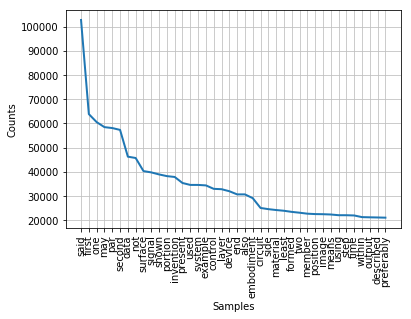

In [164]:
corpus = []
for doc in completed_patents:
    corpus.extend(doc['content'])  

freq = nltk.FreqDist(corpus)
freq.plot(40, cumulative=False)